# Dogs/Cats classifier by find-tuning VGG16
This file is dog/cat classifier built by fine-tuning a pretrained VGG16 net. 

In [1]:
%matplotlib inline

In [2]:
import os
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Lambda
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
from utils import plots, plot

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
path = "/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/dogs_cats/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=32

In [16]:
gen = ImageDataGenerator(data_format='channels_last') #data_format='channels_first'

In [4]:
train_gen = gen.flow_from_directory(path+'train', target_size=(224, 224), class_mode='categorical', shuffle=True,
                                    batch_size=batch_size)
test_gen = gen.flow_from_directory(path+'data/train2000', target_size=(224, 224), class_mode='categorical', shuffle=False,
                                   batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Fine tune the last layer

In [4]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

In [5]:
model.pop() #defined earlier model = vgg.model
for layer in model.layers: layer.trainable=False

In [6]:
model.add(Dense(2, activation='softmax'))
opt = RMSprop(lr=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.fit_generator(train_gen, steps_per_epoch=train_gen.n // batch_size, epochs=3, validation_data=test_gen, 
                    validation_steps = test_gen.n // batch_size)

Epoch 1/3
718/718 [==============================] - 412s 574ms/step - loss: 0.4070 - acc: 0.9671 - val_loss: 0.2802 - val_acc: 0.9798
Epoch 2/3
718/718 [==============================] - 292s 406ms/step - loss: 0.3474 - acc: 0.9751 - val_loss: 0.2931 - val_acc: 0.9793
Epoch 3/3
718/718 [==============================] - 292s 407ms/step - loss: 0.3423 - acc: 0.9765 - val_loss: 0.2553 - val_acc: 0.9824


In [24]:
model.save_weights(model_path+'fine_tune2000.h5')

## Class Activation Mapping
This part replace all the dense layers, and implement the class activation mapping. 

In [25]:
def global_average_pooling(x):
    return K.mean(x, axis = (2, 3))

def global_average_pooling_shape(input_shape):
    return input_shape[0:2]

In [26]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

Chop off the convolutional part of the VGG16, and make it an untrainable model. 

In [27]:
layers = model.layers
last_conv_idx = [idx for idx, layer in enumerate(layers) if type(layer) is Conv2D][-1]
conv_layers = layers[:(last_conv_idx+1)]

conv_model = Sequential(conv_layers)
for layer in conv_model.layers: layer.trainable=False

Make a copy of the convolutional model, and add global average pooling layer and classification layer, then train this classifier model with data. 

In [28]:
cls_model = Sequential(conv_layers)
for layer in cls_model.layers: layer.trainable=False

cls_model.add(Lambda(global_average_pooling, output_shape=global_average_pooling_shape))
cls_model.add(Dense(2, activation = 'softmax', kernel_initializer='uniform'))
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.5, nesterov=True)
cls_model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [29]:
cls_model.fit_generator(train_gen, steps_per_epoch=train_gen.samples // batch_size, epochs=3, validation_data=test_gen, 
                         validation_steps=test_gen.samples // batch_size)

Epoch 1/3
62/62 [==============================] - 47s - loss: 0.6411 - acc: 0.9345 - val_loss: 0.1325 - val_acc: 0.9762
Epoch 2/3
62/62 [==============================] - 46s - loss: 0.0790 - acc: 0.9849 - val_loss: 0.1246 - val_acc: 0.9762
Epoch 3/3
62/62 [==============================] - 46s - loss: 0.0281 - acc: 0.9894 - val_loss: 0.1142 - val_acc: 0.9762


In [30]:
cls_model.save_weights(model_path+'cam2000.h5')

In [17]:
n_test = 1
read_gen = gen.flow_from_directory(path+'data/validate800', target_size=(224, 224), class_mode='categorical', shuffle=True,
                                    batch_size=n_test)

Found 800 images belonging to 2 classes.


In [18]:
test_batch, test_label = next(read_gen)

In [19]:
test_batch.shape

(1, 224, 224, 3)

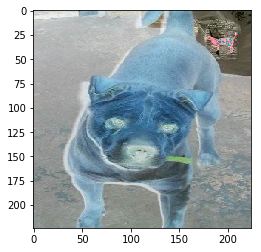

In [20]:
plt.imshow(test_batch[0])

In [6]:
test_features = conv_model.predict(test_batch, batch_size=n_test)

weights = cls_model.layers[-1].get_weights()[0]

pred_class = cls_model.predict_classes(test_batch, batch_size=n_test, verbose=0)

NameError: name 'conv_model' is not defined

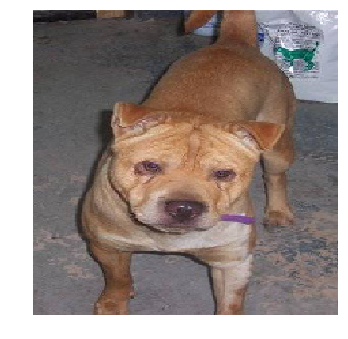

In [21]:
plots(test_batch)

In [247]:
img = test_batch[0, :, :, :]
pred_class = pred_class[0]

In [248]:
cam = np.zeros(dtype = np.float32, shape = test_features.shape[-2:])

for i, w in enumerate(weights[:, pred_class]):
    cam += test_features[0, i, :, :]*w

cam /= np.max(cam)

cam = cv2.resize(cam, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_RAINBOW)
heatmap[np.where(cam < 0.2)] = 0

heatmap_cf = np.rollaxis(heatmap, 2, 0)

img_musk = img*0.8 + heatmap_cf*0.2
batch_musk = np.zeros(dtype = np.float32, shape = (1, 3, 224, 224))
batch_musk[0, :, :, :] = img_musk

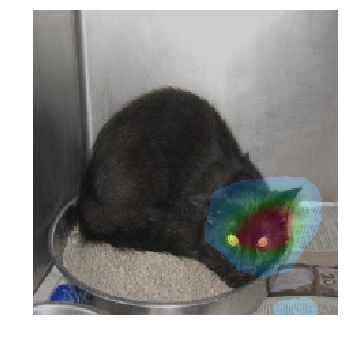

In [249]:
plots(batch_musk)

## Fine tune VGG without freezing

In [8]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

In [ ]:
layers = model.layers
last_conv_idx = [idx for idx, layer in enumerate(layers) if type(layer) is Conv2D][-1]
conv_layers = layers[:(last_conv_idx+1)]

cls_model = Sequential(conv_layers)
for layer in cls_model.layers: layer.trainable=False
#cls_model.add(Lambda(global_average_pooling, output_shape=global_average_pooling_shape))
cls_model.add(Dense(2, activation = 'softmax', kernel_initializer='uniform'))
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.5, nesterov=True)
cls_model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

## Backups
The following block tried to use the predicted features to train a fully connected last layer. But it didn't work. Probably because of the dropout of earlier layers. 

In [ ]:
train_features = model.predict_generator(train_gen, steps=train_gen.n//50, verbose=1)

test_features = model.predict_generator(test_gen, steps=test_gen.n//50, verbose=1)

train_classes = train_gen.classes
test_classes = test_gen.classes

train_labels = to_categorical(train_classes)
test_labels = to_categorical(test_classes)

fc_model = Sequential()
fc_model.add(Dense(2, input_shape=(train_features.shape[-1],)))
fc_model.add(Activation('softmax'))

opt = RMSprop(lr=0.01, rho=0.7)
fc_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

fc_model.fit(train_features, train_labels, batch_size=batch_size, epochs=10, validation_data=(test_features, test_labels))